In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.imputation.mice as mice

from sklearn.svm import SVR,SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,MinMaxScaler,OneHotEncoder,StandardScaler,LabelEncoder,RobustScaler
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error,mean_squared_error
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import make_pipeline
from scipy import stats
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet,Lasso


%matplotlib inline

In [41]:
Train=pd.read_csv('Downloads/train_house.csv',index_col=0)
Test=pd.read_csv('Downloads/test.csv',index_col=0)
print('Train shape is',Train.shape, 'and Test shape is', Test.shape)

Train shape is (1460, 80) and Test shape is (1459, 79)


In [42]:
Train_no_sales=Train.drop(columns=['SalePrice'])
Merged=pd.concat([Train_no_sales,Test],ignore_index=False,sort=False)
print(Merged.shape)

(2919, 79)


Important functions for future

In [43]:
def categorical_study_graph(Variable):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15, 10))
    sns.barplot(x=Variable, y='SalePrice',capsize=0.5, data=Train,ax=ax1)
    sns.boxplot(x=Variable,y='SalePrice',data=Train,ax=ax2)
    sns.swarmplot(x=Variable,y='SalePrice',data=Train,ax=ax2)
    sns.countplot(x=Variable,data=Train,ax=ax3)
    sns.violinplot(x=Variable,y='SalePrice',scale="count",data=Train,ax=ax4)
    plt.show()
    Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean','std','median','count']).sort_values(['mean','count'],ascending=False)
    print(Variable_df)
    return Variable_df

In [44]:
def mapper(Variable,The_map):
    Train[Variable]=Train[Variable].map(The_map)
    Test[Variable]=Test[Variable].map(The_map)
    Merged[Variable]=Merged[Variable].map(The_map)

In [45]:
def reverser(Variable_R):
    Train[Variable_R]=Train_Copy[Variable_R]
    Test[Variable_R]=Test_Copy[Variable_R]
    Merged[Variable_R]=Merged_Copy[Variable_R]

In [46]:
def catergorical_name_transformer(Variable,new_name_initials):
    Keys=list(Merged[Variable].unique())
    L=len(list(Merged[Variable].unique()))
    Values=[new_name_initials+str(i) for i in range(L)]
    Map=dict(zip(Keys,Values))
    mapper(Variable,Map)

In [47]:
def Remove_MergedTest_NotInTrain(Variable):
    Merged_element=Merged[Variable].unique()
    Train_element=Train[Variable].unique()
    Not_In_Train=[i for i in Merged_element if i not in Train_element]
    L_Not_In_Train=len(Not_In_Train)
    Top_Train_Elements=list(Train.groupby(Variable)['SalePrice'].count().sort_values()[:L_Not_In_Train].index)
    Replacement_dict=dict(zip(Not_In_Train,Top_Train_Elements))
    for i,j in Replacement_dict.items():
        Test[Variable]=Test[Variable].replace(to_replace=i, value=j)
        Merged[Variable]=Merged[Variable].replace(to_replace=i, value=j)
        print('Due to absense of'+str(i)+' in Train DataFrame, it was replaced with '+str(j))

In [48]:
def convert_nom_to_num(Variable):
    The_map=dict(zip(['TA', 'Gd', 'Fa', 'Po', 'Ex'],[0.5,0,-0.5,-1,1]))
    mapper(Variable,The_map)
    Train[Variable]=pd.to_numeric(Train[Variable],errors='coerce')
    Test[Variable]=pd.to_numeric(Test[Variable],errors='coerce')
    Merged[Variable]=pd.to_numeric(Merged[Variable],errors='coerce')

In [49]:
def Categorical_Dimension_reducer(Variable):
    
    if len(Merged[Variable].unique())!=len(Train[Variable].unique()):
        Remove_MergedTest_NotInTrain(Variable)
    if any([str(i)[0].isdigit() for i in list(Train[Variable].unique())]):
        new_name_initials=input('The categorical variables started with integers. Enter non digit initials ending with _  ')
        catergorical_name_transformer(Variable,new_name_initials)
        
    Variable_df=categorical_study_graph(Variable)
    Original_indexes=Variable_df.index
    Variable_df.insert(loc=0,column='New',value=Original_indexes)
    Variable_df.insert(loc=0,column='Original',value=Original_indexes)
    Variable_df=Variable_df.reset_index(drop=True)
    Variable_df.index.name='Index'

    L=len(list(Variable_df.index))
    counter=0
    Flag=False
    print(Variable_df)
    while Flag==False and counter<(2*L):
        counter+=1
        To_Change_row = int(input("New Index (to be changed) -1 to exit:  "))
        if To_Change_row>L or To_Change_row<-1:
            print('Wrong key pressed')
        elif To_Change_row==-1:
            Flag=True   
        else:
            Flag1=False
            counter1=0
            while Flag1==False and counter1<3:
                counter1+=1
                String=str(Variable_df.loc[To_Change_row,'New'])
                Sub = int(input("Replace "+String+" in New-column with ... from Original Index or -1:  "))
                if Sub>L or Sub<-1:
                    print('Wrong key pressed')
                elif Sub in range(L):
                    Variable_df.loc[To_Change_row,'New']=Variable_df.loc[Sub,'Original']
                    Flag1=True
                    print(Variable_df)
                elif Sub==-1:
                    Flag1=True
    print('The final version is:')
    print(Variable_df)
    print()
    The_map=dict(zip(list(Variable_df.Original),list(Variable_df.New)))
    print('The map dictionary is:')
    print(The_map)
    print()
    Train[Variable]=Train[Variable].map(The_map)
    Test[Variable]=Test[Variable].map(The_map)
    Merged[Variable]=Merged[Variable].map(The_map)
    print('The final graph is:')
    Variable_df=categorical_study_graph(Variable)
    print()
    print('Do you want to save the updates on a file on your drive?')
    Save=bool(int(input('if so, enter 1, otherwise enter 0: ')))
    if Save==True:
        Merged.to_csv(Saved_Merge)
        print('Your file name is: ',Saved_Merge)
    
    return Variable_df

In [50]:
def rem_excess_cat_el_w_diag(Variable):
    if len(Merged[Variable].unique())!=len(Train[Variable].unique()):
        Remove_MergedTest_NotInTrain(Variable)
    if any([str(i)[0].isdigit() for i in list(Train[Variable].unique())]):
        new_name_initials=input('The categorical variables started with integers. Enter non digit initials ending with _  ')
        catergorical_name_transformer(Variable,new_name_initials)
    Variable_df=categorical_study_graph(Variable)
    Original_indexes=Variable_df.index
    Variable_df.insert(loc=0,column='New',value=Original_indexes)
    Variable_df=Variable_df.reset_index(drop=True)
    Variable_df.index.name='Index'

    Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(0))
    count_min_thresh=25
    Index_count_min=Variable_df['count'].idxmin()
    count_min=Variable_df.loc[Index_count_min,'count']

    while count_min<count_min_thresh:

        if Index_count_min==0:
            Index_to_merge=1
        elif Index_count_min==len(Variable_df.index)-1:
            Index_to_merge=len(Variable_df.index)-2
        else:
            Index_count_min_1=Index_count_min+1
            if Variable_df.loc[Index_count_min,'From_Top']>=Variable_df.loc[Index_count_min+1,'From_Top']:
                Index_to_merge=Index_count_min+1
            else:
                Index_to_merge=Index_count_min-1

        to_replace=Variable_df.loc[Index_count_min,'New']
        replacer=Variable_df.loc[Index_to_merge,'New']
    
        Train[Variable]=Train[Variable].replace(to_replace=to_replace, value=replacer)
        Test[Variable]=Test[Variable].replace(to_replace=to_replace, value=replacer)
        Merged[Variable]=Merged[Variable].replace(to_replace=to_replace, value=replacer)
        Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean','count']).sort_values(['mean','count'],ascending=False)
        Original_indexes=Variable_df.index
        Variable_df.insert(loc=0,column='New',value=Original_indexes)
        Variable_df=Variable_df.reset_index(drop=True)
        Variable_df.index.name='Index'
        Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(0))
    
        Index_count_min=Variable_df['count'].idxmin()
        count_min=Variable_df.loc[Index_count_min,'count']
    
    print('After minimum count fixing, the final graph is:')
    Variable_df=categorical_study_graph(Variable)

    Original_indexes=Variable_df.index
    Variable_df.insert(loc=0,column='New',value=Original_indexes)
    Variable_df=Variable_df.reset_index(drop=True)
    Variable_df.index.name='Index'

    diff_thresh=1000
    Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(diff_thresh+1))

    Index_diff=Variable_df['From_Top'].idxmin()
    diff_min=Variable_df.loc[Index_diff,'From_Top']

    while (diff_min<diff_thresh):

        to_replace=Variable_df.loc[Index_diff,'New']
        replacer=Variable_df.loc[Index_diff-1,'New']
    
        Train[Variable]=Train[Variable].replace(to_replace=to_replace, value=replacer)
        Test[Variable]=Test[Variable].replace(to_replace=to_replace, value=replacer)
        Merged[Variable]=Merged[Variable].replace(to_replace=to_replace, value=replacer)
        Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean']).sort_values(['mean'],ascending=False)
        Original_indexes=Variable_df.index
        Variable_df.insert(loc=0,column='New',value=Original_indexes)
        Variable_df=Variable_df.reset_index(drop=True)
        Variable_df.index.name='Index'
        Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(diff_thresh+1))
    
        Index_diff_min=Variable_df['From_Top'].idxmin()
        diff_min=Variable_df.loc[Index_diff_min,'From_Top']
    
    print('After minimum count fixing, the final graph is:')
    Variable_df=categorical_study_graph(Variable)

In [51]:
def rem_excess_cat_el_w_O_diag(Variable,diff_thresh=1000,count_min_thresh=25):
    if len(Merged[Variable].unique())!=len(Train[Variable].unique()):
        Remove_MergedTest_NotInTrain(Variable)
    if any([str(i)[0].isdigit() for i in list(Train[Variable].unique())]):
        num=str(np.random.randint(0, 9999))
        new_name_initials='Input'+'_'+num+'_'
        catergorical_name_transformer(Variable,new_name_initials)
    Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean','count']).sort_values(['mean','count'],ascending=False)
    Original_indexes=Variable_df.index
    Variable_df.insert(loc=0,column='New',value=Original_indexes)
    Variable_df=Variable_df.reset_index(drop=True)
    Variable_df.index.name='Index'

    Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(0))

    Index_count_min=Variable_df['count'].idxmin()
    count_min=Variable_df.loc[Index_count_min,'count']

    while count_min<count_min_thresh:

        if Index_count_min==0:
            Index_to_merge=1
        elif Index_count_min==len(Variable_df.index)-1:
            Index_to_merge=len(Variable_df.index)-2
        else:
            Index_count_min_1=Index_count_min+1
            if Variable_df.loc[Index_count_min,'From_Top']>=Variable_df.loc[Index_count_min+1,'From_Top']:
                Index_to_merge=Index_count_min+1
            else:
                Index_to_merge=Index_count_min-1

        to_replace=Variable_df.loc[Index_count_min,'New']
        replacer=Variable_df.loc[Index_to_merge,'New']
    
        Train[Variable]=Train[Variable].replace(to_replace=to_replace, value=replacer)
        Test[Variable]=Test[Variable].replace(to_replace=to_replace, value=replacer)
        Merged[Variable]=Merged[Variable].replace(to_replace=to_replace, value=replacer)
        Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean','count']).sort_values(['mean','count'],ascending=False)
        Original_indexes=Variable_df.index
        Variable_df.insert(loc=0,column='New',value=Original_indexes)
        Variable_df=Variable_df.reset_index(drop=True)
        Variable_df.index.name='Index'
        Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(0))
    
        Index_count_min=Variable_df['count'].idxmin()
        count_min=Variable_df.loc[Index_count_min,'count']
    
    Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean']).sort_values(['mean'],ascending=False)
    Original_indexes=Variable_df.index
    Variable_df.insert(loc=0,column='New',value=Original_indexes)
    Variable_df=Variable_df.reset_index(drop=True)
    Variable_df.index.name='Index'

    Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(diff_thresh+1))

    Index_diff=Variable_df['From_Top'].idxmin()
    diff_min=Variable_df.loc[Index_diff,'From_Top']

    while (diff_min<diff_thresh):

        to_replace=Variable_df.loc[Index_diff,'New']
        replacer=Variable_df.loc[Index_diff-1,'New']
    
        Train[Variable]=Train[Variable].replace(to_replace=to_replace, value=replacer)
        Test[Variable]=Test[Variable].replace(to_replace=to_replace, value=replacer)
        Merged[Variable]=Merged[Variable].replace(to_replace=to_replace, value=replacer)
        Variable_df=Train.groupby(Variable)['SalePrice'].agg(['mean']).sort_values(['mean'],ascending=False)
        Original_indexes=Variable_df.index
        Variable_df.insert(loc=0,column='New',value=Original_indexes)
        Variable_df=Variable_df.reset_index(drop=True)
        Variable_df.index.name='Index'
        Variable_df['From_Top']=abs(Variable_df['mean'].diff(periods=1).fillna(diff_thresh+1))
    
        Index_diff_min=Variable_df['From_Top'].idxmin()
        diff_min=Variable_df.loc[Index_diff_min,'From_Top']

In [52]:
isna=Merged.isna().sum()
Merged_missing=isna[isna!=0]
Merged_missing

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [53]:
TooManyMissing=list(Merged_missing[Merged_missing>1000].index)
print(TooManyMissing)

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [54]:
Train=Train.drop(TooManyMissing,axis='columns')
Test=Test.drop(TooManyMissing,axis='columns')
Merged=Merged.drop(TooManyMissing,axis='columns')
Train_no_sales=Train_no_sales.drop(TooManyMissing,axis='columns')
Train_Copy=Train.copy()
Test_Copy=Test.copy()
Merged_Copy=Merged.copy()

In [55]:
CatCol=list(Train.select_dtypes(include='object').columns)
ConCol=list(Train.select_dtypes(exclude='object').columns)
ConCol_=list(Train.select_dtypes(exclude='object').columns)
ConCol.remove('SalePrice')

for column in ConCol:
    Train.plot(x=column,y='SalePrice',kind='scatter')
    plt.show()

In [56]:
To_drop_list=['BsmtFinSF2','LowQualFinSF','3SsnPorch','PoolArea','MiscVal']

In [57]:
Train=Train.drop(To_drop_list,axis='columns')
Test=Test.drop(To_drop_list,axis='columns')
Merged=Merged.drop(To_drop_list,axis='columns')
Train_no_sales=Train_no_sales.drop(To_drop_list,axis='columns')
Train_Copy=Train.copy()
Test_Copy=Test.copy()
Merged_Copy=Merged.copy()
ConCol=list(Train.select_dtypes(exclude='object').columns)
ConCol_=list(Train.select_dtypes(exclude='object').columns)
ConCol.remove('SalePrice')

for i in CatCol:
    sns.boxplot(x=i,y='SalePrice',data=Train)
    sns.swarmplot(x=i,y='SalePrice',data=Train)
    plt.show()
    print(Train.groupby(i)['SalePrice'].agg(['mean','std','median','count']).sort_values(['mean','count'],ascending=False))

In [58]:
To_drop_list=['Utilities','Street','LandSlope','Condition2','RoofMatl','BsmtFinType2']

In [59]:
Train=Train.drop(To_drop_list,axis='columns')
Test=Test.drop(To_drop_list,axis='columns')
Merged=Merged.drop(To_drop_list,axis='columns')
Train_no_sales=Train_no_sales.drop(To_drop_list,axis='columns')
Train_Copy=Train.copy()
Test_Copy=Test.copy()
Merged_Copy=Merged.copy()
CatCol=list(Train.select_dtypes(include='object').columns)

In [60]:
ConCol.remove('MSSubClass')
CatCol=['MSSubClass']+CatCol

In [61]:
for i in CatCol:
    print(i, Train[i].unique())
print(CatCol)

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'W

In [62]:
NomCol=['GarageCond','GarageQual','KitchenQual','HeatingQC','BsmtExposure','BsmtCond','BsmtQual','ExterQual']

for Variable in CatCol:
    rem_excess_cat_el_w_diag(Variable)

In [63]:
for Variable in CatCol:
    rem_excess_cat_el_w_O_diag(Variable,diff_thresh=1500,count_min_thresh=50)

Due to absense of150 in Train DataFrame, it was replaced with 40
Due to absense ofnan in Train DataFrame, it was replaced with C (all)
Due to absense ofnan in Train DataFrame, it was replaced with AsphShn
Due to absense ofnan in Train DataFrame, it was replaced with CBlock
Due to absense ofnan in Train DataFrame, it was replaced with Fa
Due to absense ofnan in Train DataFrame, it was replaced with Sev
Due to absense ofnan in Train DataFrame, it was replaced with Con


In [64]:
CatCol=[i for i in CatCol if i not in NomCol]
ConCol=ConCol+NomCol

In [65]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
for i in NomCol:
    Merged[i] = Merged[i].map(bin_map)
    Train[i] = Train[i].map(bin_map)
    Test[i] = Test[i].map(bin_map)
Merged_Copy=Merged.copy()

Merged_isna=Merged.isna()
Merged_isna_columns=list(Merged.isna().any()[Merged.isna().any()==True].index)

print(Merged_isna_columns)

C=list(Merged['LotFrontage'][Merged['LotFrontage'].isna()].index)
print(C)

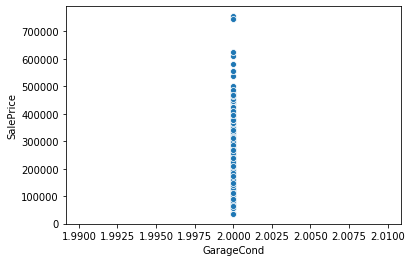

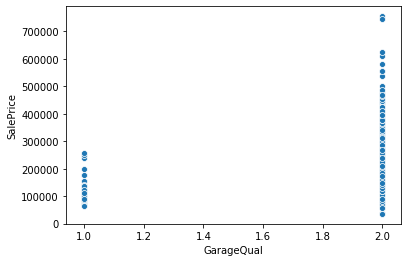

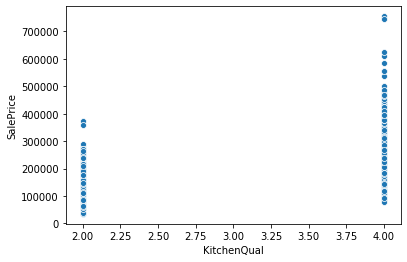

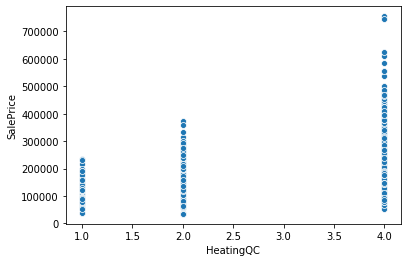

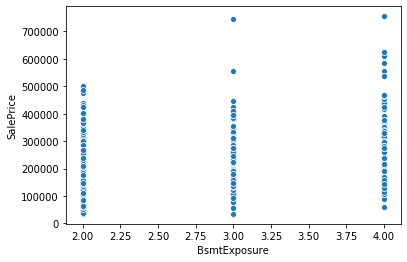

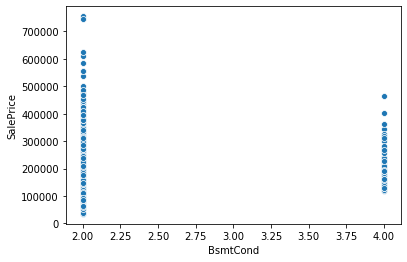

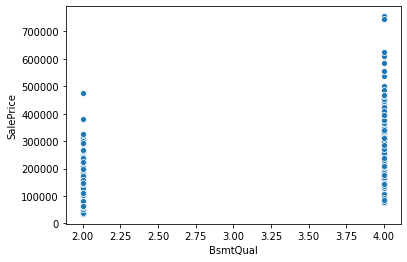

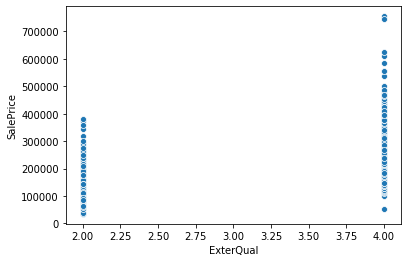

In [66]:
for i in NomCol:
    sns.scatterplot(x=i,y='SalePrice',data=Train)
    plt.show()

In [67]:
for i in ConCol:
    Filler=0
    Merged[i]=Merged[i].fillna(Filler)
    Train[i]=Train[i].fillna(Filler)
    Test[i]=Test[i].fillna(Filler)

In [68]:
for i in CatCol:
    Filler=Train[i].mode().iloc[0]
    Merged[i]=Merged[i].fillna(Filler)
    Train[i]=Train[i].fillna(Filler)
    Test[i]=Test[i].fillna(Filler)

In [69]:
print(Merged[CatCol].isna().sum().sum())
print(Merged[ConCol].isna().sum().sum())

0
0


In [70]:
sc1=StandardScaler()
Train=Merged.iloc[:1460]
Test=Merged.iloc[1460:]

In [71]:
TrainContinuous = sc1.fit_transform(Train[ConCol])
TestContinuous = sc1.transform(Test[ConCol])


One_Hot = OneHotEncoder().fit(Train[CatCol])
TrainCategorical = One_Hot.transform(Train[CatCol]).toarray()
TestCategorical = One_Hot.transform(Test[CatCol]).toarray()
TrainX = np.hstack((TrainCategorical, TrainContinuous))
TestX = np.hstack((TestCategorical, TestContinuous))
y=Train_Copy['SalePrice'].values
print(TrainX.shape)

(1460, 132)


In [72]:
linear_regression = LinearRegression()
random_state=10

In [73]:
X_train, X_test, y_train, y_test = train_test_split(TrainX, y, test_size= 0.33, random_state = random_state)

In [74]:
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)
score=mean_squared_error(y_test, y_pred, squared= False)
print(f'LinearRegression Score= {score}')

LinearRegression Score= 29334.42358429464


In [75]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

In [76]:
y=Train_Copy['SalePrice'].values

In [77]:
reg=gradient_boosting_regressor.fit(TrainX, y)
Test['SalePrice']=reg.predict(TestX)
prediction_df=Test[['SalePrice']]
prediction_df.to_csv('Downloads/Datascience/KaggleStuff/Housing_prediction.csv')

C:\Users\Dara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
prediction_df.head()

,SalePrice
Id,
1461,119351.049238
1462,162182.858003
1463,189556.016392
1464,201060.962318
1465,178278.466529


In [84]:
xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = random_state)

In [85]:
reg=xgb_regressor.fit(TrainX, y)
Test['SalePrice']=reg.predict(TestX)
prediction_df=Test[['SalePrice']]
prediction_df.to_csv('Downloads/Datascience/KaggleStuff/Housing_prediction.csv')

C:\Users\Dara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
lgbm_regressor= lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                                  random_state = random_state)

In [96]:
reg=lgbm_regressor.fit(TrainX, y)
Test['SalePrice']=reg.predict(TestX)
prediction_df=Test[['SalePrice']]
prediction_df.to_csv('Downloads/Datascience/KaggleStuff/Housing_prediction.csv')

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\Dara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
